In [1]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
import os

In [2]:
# Use CPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
print(tensorflow.__version__)

2.8.0


In [4]:
# Dataset
df=pd.read_csv('./../../dataset/raw_jakarta.csv', parse_dates=["date"], index_col="date")
#df['daily_case'] = df['daily_case'].str.replace(',','').astype(int)

# Cut dataset to start from 1 April 2022
df = df[31:]
df.head()

,daily_case
date,
2020-04-01,59
2020-04-02,70
2020-04-03,71
2020-04-04,57
2020-04-05,87


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 766 entries, 2020-04-01 to 2022-05-06
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   daily_case  766 non-null    int64
dtypes: int64(1)
memory usage: 12.0 KB


In [6]:
df.shape

(766, 1)

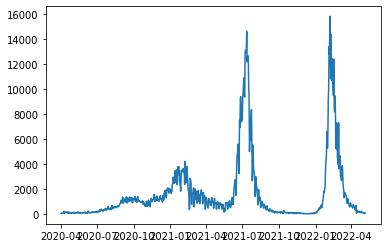

In [7]:
plt.plot(df)

In [8]:
scaler = MinMaxScaler(feature_range=(0,1))

In [9]:
df.shape

(766, 1)

In [10]:
df.head()

,daily_case
date,
2020-04-01,59
2020-04-02,70
2020-04-03,71
2020-04-04,57
2020-04-05,87


In [11]:
# df = scaler.fit_transform(np.array(df).reshape(-1,1))

In [12]:
df.shape

(766, 1)

In [13]:
# Split data to train and test
df = df.values
df = df.astype('float32')
train_size = int(len(df) * 0.75)
test_size=len(df)-train_size

In [14]:
train_data=df[0:train_size,:]
test_data=df[train_size:len(df),:]

In [15]:
# scale data
train_data = scaler.fit_transform(np.array(train_data).reshape(-1,1))
test_data = scaler.fit_transform(np.array(test_data).reshape(-1,1))

In [16]:
train_data.shape

(574, 1)

In [17]:
print(len(train_data)), print(len(test_data))

574
192


(None, None)

In [18]:
# Create dataset matrix based on timestep
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

In [19]:
# Reshape into x=t, t+1, t+2, ... t+n, and Y = t + (n+1)
time_step = 30
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

In [20]:
print(X_train.shape), print(Y_train.shape)

(543, 30)
(543,)


(None, None)

In [21]:
print(X_test.shape), print(Y_test.shape)

(161, 30)
(161,)


(None, None)

In [22]:
len(X_test)

161

In [23]:
# Reshape input data to 3d [sample, time_step, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [24]:
# # Create model
# model = Sequential()
# model.add(LSTM(192, return_sequences=True, input_shape=(30,1)))
# model.add(LSTM(64, return_sequences=True))
# model.add(LSTM(224, return_sequences=True))
# model.add(LSTM(160, activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mean_squared_error')

In [25]:
# Create Stacked LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(30,1)))
model.add(LSTM(100))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=200, batch_size=32, verbose=1)

Epoch 1/200
17/17 [==============================] - 3s 52ms/step - loss: 0.0130 - val_loss: 0.0227
Epoch 2/200
17/17 [==============================] - 0s 28ms/step - loss: 0.0064 - val_loss: 0.0116
Epoch 3/200
17/17 [==============================] - 0s 29ms/step - loss: 0.0032 - val_loss: 0.0095
Epoch 4/200
17/17 [==============================] - 0s 29ms/step - loss: 0.0028 - val_loss: 0.0071
Epoch 5/200
17/17 [==============================] - 1s 30ms/step - loss: 0.0028 - val_loss: 0.0067
Epoch 6/200
17/17 [==============================] - 0s 29ms/step - loss: 0.0029 - val_loss: 0.0066
Epoch 7/200
17/17 [==============================] - 0s 27ms/step - loss: 0.0026 - val_loss: 0.0063
Epoch 8/200
17/17 [==============================] - 0s 28ms/step - loss: 0.0022 - val_loss: 0.0076
Epoch 9/200
17/17 [==============================] - 0s 28ms/step - loss: 0.0020 - val_loss: 0.0059
Epoch 10/200
17/17 [==============================] - 0s 28ms/step - loss: 0.0021 - val_loss: 0.0069

17/17 [==============================] - 1s 32ms/step - loss: 7.8283e-04 - val_loss: 0.0034
Epoch 162/200
17/17 [==============================] - 1s 31ms/step - loss: 7.9597e-04 - val_loss: 0.0042
Epoch 163/200
17/17 [==============================] - 0s 29ms/step - loss: 8.6875e-04 - val_loss: 0.0033
Epoch 164/200
17/17 [==============================] - 0s 27ms/step - loss: 8.2722e-04 - val_loss: 0.0032
Epoch 165/200
17/17 [==============================] - 0s 28ms/step - loss: 8.6050e-04 - val_loss: 0.0039
Epoch 166/200
17/17 [==============================] - 0s 27ms/step - loss: 7.9816e-04 - val_loss: 0.0036
Epoch 167/200
17/17 [==============================] - 0s 27ms/step - loss: 7.8194e-04 - val_loss: 0.0037
Epoch 168/200
17/17 [==============================] - 0s 27ms/step - loss: 9.0158e-04 - val_loss: 0.0033
Epoch 169/200
17/17 [==============================] - 0s 28ms/step - loss: 7.9289e-04 - val_loss: 0.0033
Epoch 170/200
17/17 [==============================] - 0s 27

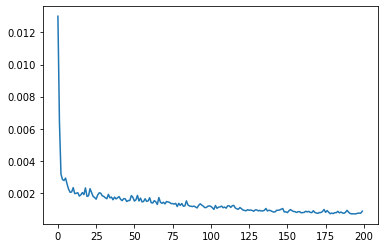

In [28]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [29]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [30]:
# Transform back to original value
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [31]:
# Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(Y_train, train_predict))

3086.163637916823

In [32]:
math.sqrt(mean_squared_error(Y_test, test_predict))

4503.448456460893

In [33]:
train_predict

array([[   30.288363],
       [   29.014696],
       [   27.467585],
       [   36.073254],
       [   38.38822 ],
       [   44.94845 ],
       [   42.05499 ],
       [   34.426834],
       [   32.323704],
       [   34.13466 ],
       [   39.74211 ],
       [   37.312374],
       [   37.359966],
       [   45.8304  ],
       [   41.047287],
       [   31.802109],
       [   33.943054],
       [   43.75592 ],
       [   44.69951 ],
       [   44.514355],
       [   39.609528],
       [   33.030098],
       [   33.402203],
       [   34.159397],
       [   34.218506],
       [   30.755325],
       [   32.66721 ],
       [   37.78776 ],
       [   38.29772 ],
       [   38.371788],
       [   33.972977],
       [   32.218655],
       [   38.29831 ],
       [   32.572174],
       [   36.797497],
       [   43.24858 ],
       [   40.256046],
       [   40.202507],
       [   41.71637 ],
       [   30.2949  ],
       [   43.63429 ],
       [   43.89787 ],
       [   42.559444],
       [   

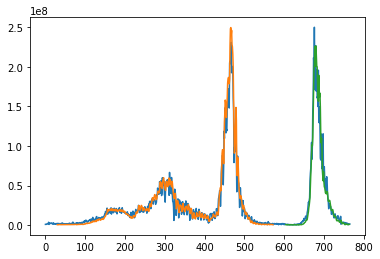

In [34]:
# Plot 
look_back = 30
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

#shift test predict
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict

#plot baseline
plt.plot(scaler.inverse_transform(df))
plt.plot(scaler.inverse_transform(trainPredictPlot))
plt.plot(scaler.inverse_transform(testPredictPlot))
plt.show()

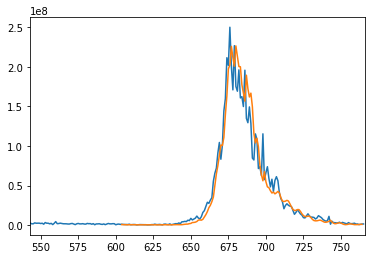

In [35]:
#shift test predict
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict

#plot baseline
plt.plot(scaler.inverse_transform(df))
plt.plot(scaler.inverse_transform(testPredictPlot))
plt.xlim(X_train.shape[0], df.shape[0])
plt.show()

In [36]:
len(test_data)

192

In [37]:
x_input=test_data[162:].reshape(1,-1) #test data - step(30)
x_input.shape

(1, 30)

In [38]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [39]:
temp_input

[0.04174308851361275,
 0.036556825041770935,
 0.027575738728046417,
 0.02245272323489189,
 0.018847638741135597,
 0.021567264571785927,
 0.043324265629053116,
 0.0036683320067822933,
 0.018721144646406174,
 0.011321231722831726,
 0.01144772581756115,
 0.009866548702120781,
 0.010435772128403187,
 0.013724621385335922,
 0.009170830249786377,
 0.01271266769617796,
 0.009993042796850204,
 0.0076528992503881454,
 0.005502498243004084,
 0.011700714007019997,
 0.007336664013564587,
 0.006261463277041912,
 0.00708367582410574,
 0.008664852939546108,
 0.0042375558987259865,
 0.004680285695940256,
 0.0016444247448816895,
 0.0030358610674738884,
 0.004490544553846121,
 0.004743532743304968]

In [40]:
# prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=30
i=0
while(i<30): #30 hari
    
    if(len(temp_input)>30):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.00176488]
31
1 day input [0.03655683 0.02757574 0.02245272 0.01884764 0.02156726 0.04332427
 0.00366833 0.01872114 0.01132123 0.01144773 0.00986655 0.01043577
 0.01372462 0.00917083 0.01271267 0.00999304 0.0076529  0.0055025
 0.01170071 0.00733666 0.00626146 0.00708368 0.00866485 0.00423756
 0.00468029 0.00164442 0.00303586 0.00449054 0.00474353 0.00176488]
1 day output [[0.00090111]]
2 day input [0.02757574 0.02245272 0.01884764 0.02156726 0.04332427 0.00366833
 0.01872114 0.01132123 0.01144773 0.00986655 0.01043577 0.01372462
 0.00917083 0.01271267 0.00999304 0.0076529  0.0055025  0.01170071
 0.00733666 0.00626146 0.00708368 0.00866485 0.00423756 0.00468029
 0.00164442 0.00303586 0.00449054 0.00474353 0.00176488 0.00090111]
2 day output [[0.00069315]]
3 day input [0.02245272 0.01884764 0.02156726 0.04332427 0.00366833 0.01872114
 0.01132123 0.01144773 0.00986655 0.01043577 0.01372462 0.00917083
 0.01271267 0.00999304 0.0076529  0.0055025  0.01170071 0.00733666
 0.00626146 0.007083

25 day input [4.68028570e-03 1.64442474e-03 3.03586107e-03 4.49054455e-03
 4.74353274e-03 1.76488422e-03 9.01114196e-04 6.93146139e-04
 1.09946355e-03 1.59144960e-03 1.66789070e-03 1.23056956e-03
 5.77269122e-04 1.18296593e-04 1.23232603e-05 2.88218260e-04
 6.50614500e-04 7.88267702e-04 6.03673980e-04 2.61498615e-04
 1.18501484e-05 4.69945371e-06 2.34000385e-04 4.92941588e-04
 5.84332272e-04 4.62517142e-04 2.52621248e-04 9.66768712e-05
 1.05857849e-04 2.58723274e-04]
25 day output [[0.00042344]]
26 day input [1.64442474e-03 3.03586107e-03 4.49054455e-03 4.74353274e-03
 1.76488422e-03 9.01114196e-04 6.93146139e-04 1.09946355e-03
 1.59144960e-03 1.66789070e-03 1.23056956e-03 5.77269122e-04
 1.18296593e-04 1.23232603e-05 2.88218260e-04 6.50614500e-04
 7.88267702e-04 6.03673980e-04 2.61498615e-04 1.18501484e-05
 4.69945371e-06 2.34000385e-04 4.92941588e-04 5.84332272e-04
 4.62517142e-04 2.52621248e-04 9.66768712e-05 1.05857849e-04
 2.58723274e-04 4.23438847e-04]
26 day output [[0.00046855]

In [41]:
day_new=np.arange(1,31) # dari data 30 hari terakhir
day_pred=np.arange(31,61) #predict 30 hari kedepan

In [42]:
len(df)

766

In [43]:
len(day_pred)

30

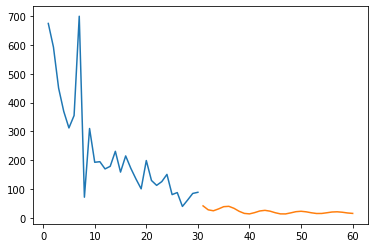

In [44]:
plt.plot(day_new,df[736:]) # [total data - prediction(30)] 
plt.plot(day_pred,scaler.inverse_transform(lst_output))

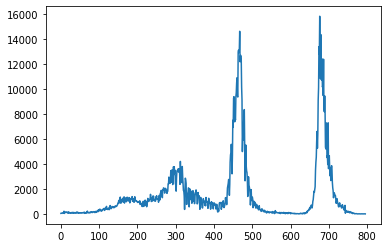

In [45]:
df2=df.tolist()
df2.extend(scaler.inverse_transform(lst_output))
plt.plot(df2)

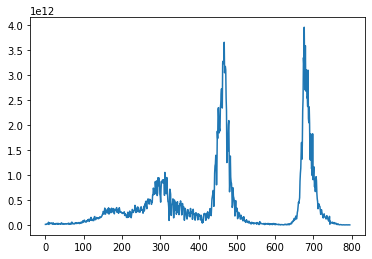

In [48]:
df2=scaler.inverse_transform(df2).tolist()
plt.plot(df2)

In [59]:
# evaluate the model
scores = model.evaluate(X_train, Y_train, verbose=0)
print("%s: %f" % (model.metrics_names[0], scores*100))

loss: 0.082946


In [60]:
# save model and architecture to single file
model.save("lstm_jakarta.h5")
print("Saved model to disk")

Saved model to disk


In [61]:
from keras.models import load_model
 
# load model
model = load_model('lstm_jakarta.h5')
# summarize model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________
